# Test analysis

In [162]:
import matplotlib.pyplot as plt
import tikzplotlib as tikz
import seaborn as sns
import polars as pl

In [163]:
import os

class Dataset:
    def __init__(self, name: str, path: str, max_iterations: int = 15):
        self.path = path
        self.name = name
        self.data = {}
        self.max_iterations = max_iterations

        file_template = 'test_cases_iter_{number}_results.csv'

        # For every csv file in the path, read it and store it in self.data
        for file in os.listdir(path):
            if file.endswith('.csv') and any(
                file_template.format(number=i) in file for i in range(max_iterations)
            ):
                full_path = os.path.join(path, file)
                self.data[file] = pl.read_csv(full_path)

    def get_data_by_iteration(self, iteration: int):
        # Return the dataframe for the specified iteration
        file_name = f'test_cases_iter_{iteration}_results.csv'
        if file_name in self.data:
            return self.data[file_name]
        else:
            raise ValueError(f"No data found for iteration {iteration}")
        
    def get_merged_real_test_cases_weakness_count(self):
        merged_data = self.get_merged_data()
        if 'Test Case Weakness' in merged_data.columns:
            return merged_data['Test Case Weakness'].value_counts()
        else:
            raise ValueError("Column 'Test Case Weakness' not found in merged data")
    
    def get_accuracies_by_weakness(self, relaxed: bool = False):
        # Return a dictionary with accuracies for each weakness
        merged_data = self.get_merged_data()
        if 'Test Case Weakness' not in merged_data.columns:
            raise ValueError("Column 'Test Case Weakness' not found in merged data")
        
        weaknesses = merged_data['Test Case Weakness'].unique().to_list()
        accuracies = {}
        
        for weakness in weaknesses:
            df = merged_data.filter(pl.col('Test Case Weakness') == weakness)
            if relaxed:
                accuracies[weakness] = (sum(df['LLM Hit CWE']) * 100) / len(df)
            else:
                accuracies[weakness] = (sum(df['LLM Hit Code']) * 100) / len(df)
        
        return accuracies
    
    def get_accuracy_by_iteration(self, iteration: int, relaxed: bool = False):
        # Return the accuracy for the specified iteration
        df = self.get_data_by_iteration(iteration)
        if relaxed:
            return (sum(df['LLM Hit CWE']) * 100) / len(df)
        else:
            return (sum(df['LLM Hit Code']) * 100) / len(df)
    
    def get_accuracies_by_iterations(self, relaxed: bool = False):
        # Return a dictionary with accuracies for all iterations
        accuracies = []
        for i in range(self.max_iterations):
            try:
                accuracies.append(self.get_accuracy_by_iteration(i, relaxed))
            except ValueError:
                raise ValueError(f"No data found for iteration {i}")
        return accuracies

    def get_merged_accuracy(self, relaxed: bool = False):
        # Merge all dataframes and calculate accuracy
        merged_data = self.get_merged_data()
        if relaxed:
            return (sum(merged_data['LLM Hit CWE']) * 100) / len(merged_data)
        else:
            return (sum(merged_data['LLM Hit Code']) * 100) / len(merged_data)
        
    def get_merged_data(self):
        # Merge all dataframes in self.data into a single dataframe
        merged_data = pl.concat(list(self.data.values()), how='vertical')
        return merged_data
    
class DatasetCollection:
    def __init__(self, datasets: list[Dataset]):
        self.datasets = {}
        for dataset in datasets:
            self.add_dataset(dataset)

    def add_dataset(self, dataset: Dataset):
        self.datasets[dataset.name] = dataset

    def get_dataset(self, name: str) -> Dataset:
        if name in self.datasets:
            return self.datasets[name]
        else:
            raise ValueError(f"Dataset '{name}' not found")
        
    def get_merged_data(self):
        # Merge all datasets into a single dataframe
        merged_data = pl.concat([dataset.get_merged_data() for dataset in self.datasets.values()], how='vertical')
        return merged_data
    
    def get_merged_data_per_iteration(self, iteration: int):
        iterations_data = {}
        for dataset in self.datasets.values():
            dataset_data = dataset.get_data_by_iteration(iteration)
            iterations_data[dataset.name] = dataset_data

        # Merge all datasets for the specified iteration
        merged_data = pl.concat(list(iterations_data.values()), how='vertical')
        return merged_data
    
    def get_merged_per_iteration_accuracies(self, relaxed: bool = False):
        accuracies = []
        # Get merged data and calculate accuracies per iteration
        for iteration in range(self.datasets[list(self.datasets.keys())[0]].max_iterations):
            iterations_data = self.get_merged_data_per_iteration(iteration)
            if relaxed:
                accuracies.append((sum(iterations_data['LLM Hit CWE']) * 100) / len(iterations_data))
            else:
                accuracies.append((sum(iterations_data['LLM Hit Code']) * 100) / len(iterations_data))
        return accuracies
        
    def get_merged_per_iteration_weakness_accuracies(self, iteration: int, weakness: str, relaxed: bool = False):
        # Get merged data for the specified iteration and calculate accuracy for the specified weakness
        iteration_data = self.get_merged_data_per_iteration(iteration)
        if 'Test Case Weakness' not in iteration_data.columns:
            raise ValueError("Column 'Test Case Weakness' not found in merged data")
        
        df = iteration_data.filter(pl.col('Test Case Weakness') == weakness)
        if relaxed:
            return (sum(df['LLM Hit CWE']) * 100) / len(df)
        else:
            return (sum(df['LLM Hit Code']) * 100) / len(df)
        
    def get_merged_per_iteration_weaknessses_accuracies(self, relaxed: bool = False):
        weaknesses = self.get_merged_real_test_cases_weakness_count()['Test Case Weakness']
        weaknesses_accuracies = {}

        for weakness in weaknesses:
            weaknesses_accuracies[weakness] = []
        
        for iter in range(self.datasets[list(self.datasets.keys())[0]].max_iterations):
            for weakness in weaknesses_accuracies.keys():
                accuracy = self.get_merged_per_iteration_weakness_accuracies(iter, weakness, relaxed)
                weaknesses_accuracies[weakness].append(accuracy)

        return weaknesses_accuracies
    
    def get_merged_per_weakness_accuracy(self, relaxed: bool = False):
        # Get merged data and calculate accuracy per weakness
        merged_data = self.get_merged_data()
        if 'Test Case Weakness' not in merged_data.columns:
            raise ValueError("Column 'Test Case Weakness' not found in merged data")
        
        weaknesses = merged_data['Test Case Weakness'].unique().to_list()
        accuracies = {}
        
        for weakness in weaknesses:
            df = merged_data.filter(pl.col('Test Case Weakness') == weakness)
            if relaxed:
                accuracies[weakness] = (sum(df['LLM Hit CWE']) * 100) / len(df)
            else:
                accuracies[weakness] = (sum(df['LLM Hit Code']) * 100) / len(df)
        
        return accuracies
    
    def get_merged_real_test_cases_weakness_count(self):
        # Get merged data and count weaknesses
        merged_data = self.get_merged_data()
        if 'Test Case Weakness' in merged_data.columns:
            return merged_data['Test Case Weakness'].value_counts()
        else:
            raise ValueError("Column 'Test Case Weakness' not found in merged data")
    
    def get_merged_accuracy(self, relaxed: bool = False):
        # Merge all datasets and calculate accuracy
        merged_data = self.get_merged_data()
        if relaxed:
            return (sum(merged_data['LLM Hit CWE']) * 100) / len(merged_data)
        else:
            return (sum(merged_data['LLM Hit Code']) * 100) / len(merged_data)

In [164]:
max_iterations = 15
csharp_data = Dataset(
    'C#',
    'results/csharp',
    max_iterations=max_iterations
)

php_data = Dataset(
    'PHP',
    'results/php',
    max_iterations=max_iterations
)

all_datasets = DatasetCollection(
    datasets=[csharp_data, php_data]
)

In [165]:
all_data = [csharp_data, php_data]

# Weaknesses

In [166]:
csharp_data.get_merged_real_test_cases_weakness_count()

Test Case Weakness,count
str,u32
"""CWE-22""",117
"""CWE-90""",111
"""CWE-89""",946
"""CWE-78""",108
"""CWE-91""",218


In [167]:
php_data.get_merged_real_test_cases_weakness_count()

Test Case Weakness,count
str,u32
"""CWE-90""",352
"""CWE-91""",189
"""CWE-78""",93
"""CWE-89""",185
"""CWE-79""",681


In [168]:
all_datasets.get_merged_real_test_cases_weakness_count()

Test Case Weakness,count
str,u32
"""CWE-91""",407
"""CWE-78""",201
"""CWE-22""",117
"""CWE-89""",1131
"""CWE-90""",463
"""CWE-79""",681


# Real accuracy

In [169]:
def collect_accuracies(datasets, relaxed=False):
    records = []
    for dataset in datasets:
        for i in range(len(dataset.data)):
            try:
                acc = float(dataset.get_accuracy_by_iteration(i, relaxed=relaxed))
                records.append({
                    "Dataset": dataset.name,
                    "Iteration": i,
                    "Accuracy": acc
                })
            except Exception:
                continue
    return pl.DataFrame(records)

def collect_accuracies_general(datasets: DatasetCollection, relaxed=False):
    records = []
    accuracies = datasets.get_merged_per_iteration_accuracies(relaxed=relaxed)
    for i, acc in enumerate(accuracies):
        records.append({
            "Dataset": "General",
            "Iteration": i,
            "Accuracy": acc
        })
    return pl.DataFrame(records)

def plot_real_accuray(datasets: list[Dataset]):
    df = collect_accuracies(datasets, relaxed=False)
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x="Dataset", y="Accuracy", palette="pastel", inner="box")
    plt.title("Accuracy Distribution by Dataset")
    plt.xticks(rotation=45)
    plt.tight_layout()
    tikz.save('tikz/real_accuracy_distribution.tex')
    plt.show()

def plot_real_accuracy_general(datasets: DatasetCollection):
    df = collect_accuracies_general(datasets, relaxed=False)
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x="Dataset", y="Accuracy", palette="pastel", inner="box")
    plt.title("General Accuracy Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    tikz.save('tikz/real_accuracy_distribution_general.tex')
    plt.show()

def plot_relaxed_accuracy(datasets: list[Dataset]):
    df = collect_accuracies(datasets, relaxed=True)
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x="Dataset", y="Accuracy", palette="pastel", inner="box")
    plt.title("Relaxed Accuracy Distribution by Dataset")
    plt.xticks(rotation=45)
    plt.tight_layout()
    tikz.save('tikz/relaxed_accuracy_distribution.tex')
    plt.show()

def plot_relaxed_accuracy_general(datasets: DatasetCollection):
    df = collect_accuracies_general(datasets, relaxed=True)
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x="Dataset", y="Accuracy", palette="pastel", inner="box")
    plt.title("General Relaxed Accuracy Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    tikz.save('tikz/relaxed_accuracy_distribution_general.tex')
    plt.show()

/var/folders/_2/d0jdk4lx3hl2vhm1490_4rm40000gn/T/ipykernel_13316/1485983519.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




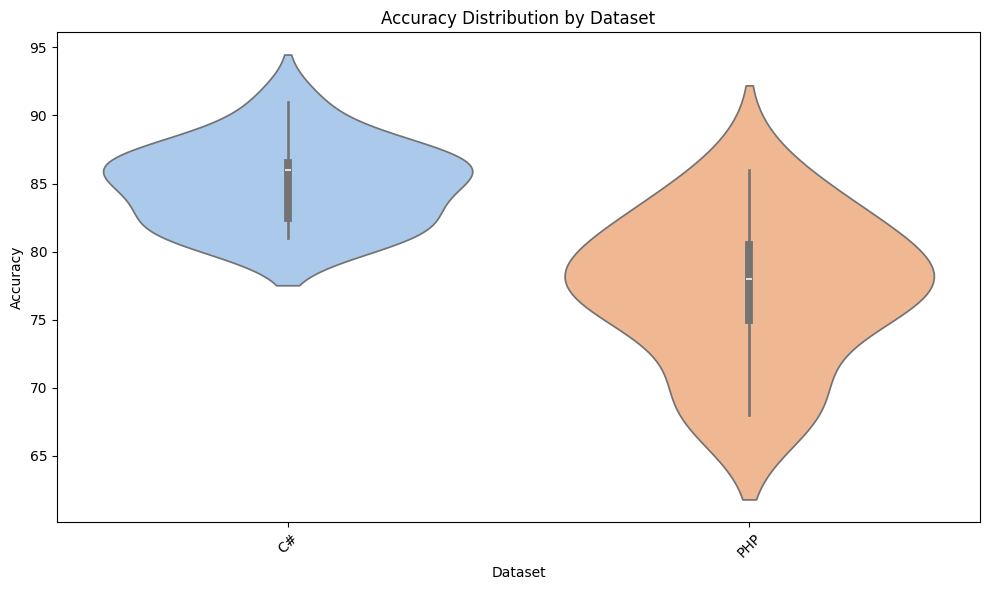

In [170]:
plot_real_accuray(all_data)

/var/folders/_2/d0jdk4lx3hl2vhm1490_4rm40000gn/T/ipykernel_13316/1485983519.py:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




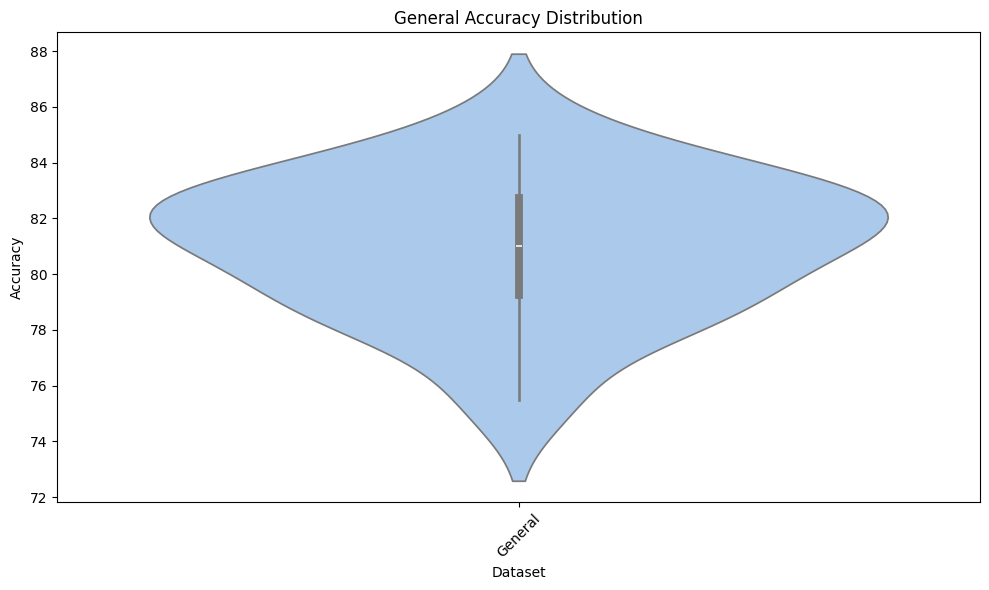

In [171]:
plot_real_accuracy_general(all_datasets)

# Control chart

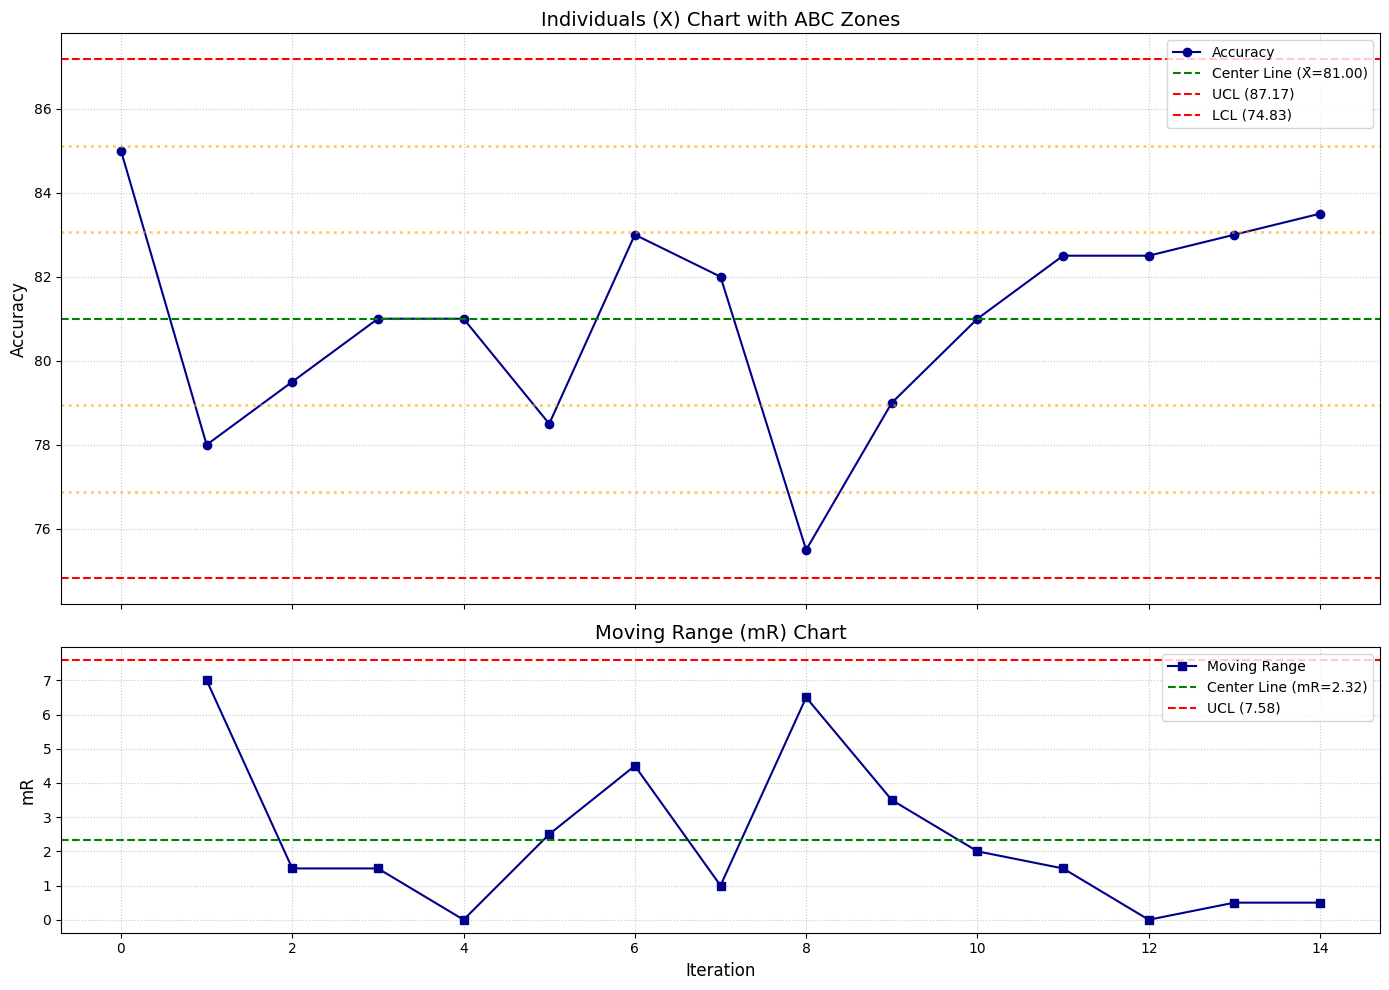

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statprocon import XmR

# Your accuracy data (replace with your actual data source)
accuracies = all_datasets.get_merged_per_iteration_accuracies()
data = pd.Series(accuracies)

# Create XmR object
xmr = XmR(data)

# --- Individuals (X) chart limits ---
x_cl = xmr.x_central_line()[0]
unpl = xmr.upper_natural_process_limit()[0]
lnpl = xmr.lower_natural_process_limit()[0]

# ABC zones (as thirds of the control range)
zone_step = (unpl - lnpl) / 6

# --- Moving Range (mR) chart data ---
mr_values = xmr.moving_ranges()[1:]
mr_iterations = np.arange(1, len(data))
mr_cl = xmr.mr_central_line()[0]
url = xmr.upper_range_limit()[0]

# Plot setup: 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# === Plot X chart ===
iterations = np.arange(len(data))
ax1.plot(iterations, data, marker='o', linestyle='-', color='darkblue', label='Accuracy')

# Control limits and center line
ax1.axhline(y=x_cl, color='green', linestyle='--', linewidth=1.5, label=f'Center Line (X̄={x_cl:.2f})')
ax1.axhline(y=unpl, color='red', linestyle='--', linewidth=1.5, label=f'UCL ({unpl:.2f})')
ax1.axhline(y=lnpl, color='red', linestyle='--', linewidth=1.5, label=f'LCL ({lnpl:.2f})')

# ABC zones
for i, zone in zip([1, 2], ['Zone C (±1)', 'Zone B (±2)']):
    ax1.axhline(y=x_cl + i * zone_step, color='orange', linestyle=':', linewidth=2, alpha=0.6)
    ax1.axhline(y=x_cl - i * zone_step, color='orange', linestyle=':', linewidth=2, alpha=0.6)

ax1.set_title("Individuals (X) Chart with ABC Zones", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend(loc='upper right')

# === Plot mR chart ===
ax2.plot(mr_iterations, mr_values, marker='s', linestyle='-', color='darkblue', label='Moving Range')
ax2.axhline(y=mr_cl, color='green', linestyle='--', linewidth=1.5, label=f'Center Line (mR={mr_cl:.2f})')
ax2.axhline(y=url, color='red', linestyle='--', linewidth=1.5, label=f'UCL ({url:.2f})')

ax2.set_title("Moving Range (mR) Chart", fontsize=14)
ax2.set_xlabel("Iteration", fontsize=12)
ax2.set_ylabel("mR", fontsize=12)
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend(loc='upper right')

# Final formatting
plt.tight_layout()
tikz.save('tikz/xmr_chart.tex')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statprocon import XmR

# Your accuracy data (replace with your actual data source)
accuracies = php_data.get_accuracies_by_iterations() + csharp_data.get_accuracies_by_iterations()
data = pd.Series(accuracies)

# Create XmR object
xmr = XmR(data)

# --- Individuals (X) chart limits ---
x_cl = xmr.x_central_line()[0]
unpl = xmr.upper_natural_process_limit()[0]
lnpl = xmr.lower_natural_process_limit()[0]

# ABC zones (as thirds of the control range)
zone_step = (unpl - lnpl) / 6

# --- Moving Range (mR) chart data ---
mr_values = xmr.moving_ranges()[1:]
mr_iterations = np.arange(1, len(data))
mr_cl = xmr.mr_central_line()[0]
url = xmr.upper_range_limit()[0]

# Plot setup: 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# === Plot X chart ===
iterations = np.arange(len(data))
ax1.plot(iterations, data, marker='o', linestyle='-', color='darkblue', label='Accuracy')

# Control limits and center line
ax1.axhline(y=x_cl, color='green', linestyle='--', linewidth=1.5, label=f'Center Line (X̄={x_cl:.2f})')
ax1.axhline(y=unpl, color='red', linestyle='--', linewidth=1.5, label=f'UCL ({unpl:.2f})')
ax1.axhline(y=lnpl, color='red', linestyle='--', linewidth=1.5, label=f'LCL ({lnpl:.2f})')

# ABC zones
for i, zone in zip([1, 2], ['Zone C (±1)', 'Zone B (±2)']):
    ax1.axhline(y=x_cl + i * zone_step, color='orange', linestyle=':', linewidth=2, alpha=0.6)
    ax1.axhline(y=x_cl - i * zone_step, color='orange', linestyle=':', linewidth=2, alpha=0.6)

ax1.set_title("Individuals (X) Chart with ABC Zones", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend(loc='upper right')

# === Plot mR chart ===
ax2.plot(mr_iterations, mr_values, marker='s', linestyle='-', color='darkblue', label='Moving Range')
ax2.axhline(y=mr_cl, color='green', linestyle='--', linewidth=1.5, label=f'Center Line (mR={mr_cl:.2f})')
ax2.axhline(y=url, color='red', linestyle='--', linewidth=1.5, label=f'UCL ({url:.2f})')

ax2.set_title("Moving Range (mR) Chart", fontsize=14)
ax2.set_xlabel("Iteration", fontsize=12)
ax2.set_ylabel("mR", fontsize=12)
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend(loc='upper right')

# Final formatting
plt.tight_layout()
tikz.save('tikz/xmr_chart.tex')
plt.show()

# Relaxed Accuracy

/var/folders/_2/d0jdk4lx3hl2vhm1490_4rm40000gn/T/ipykernel_13316/1485983519.py:50: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




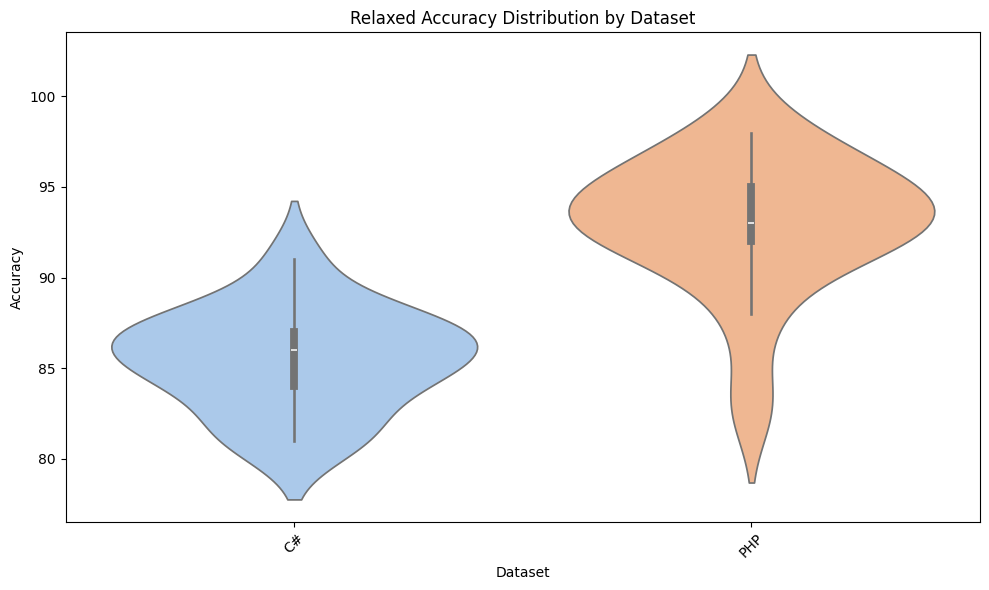

In [173]:
plot_relaxed_accuracy(all_data)

# Per weakness

In [174]:
def plot_per_weakness_accuracy(datasets: DatasetCollection, relaxed=False):
    accuracies = datasets.get_merged_per_weakness_accuracy(relaxed=relaxed)
    df = pl.DataFrame({
        "Weakness": list(accuracies.keys()),
        "Accuracy": list(accuracies.values())
    }).sort("Accuracy", descending=True)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="Weakness", y="Accuracy", palette="pastel")
    plt.title("Accuracy by Weakness")
    plt.xticks(rotation=45)
    plt.tight_layout()
    tikz.save('tikz/weakness_accuracy_bar.tex')
    plt.show()

/var/folders/_2/d0jdk4lx3hl2vhm1490_4rm40000gn/T/ipykernel_13316/498057289.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




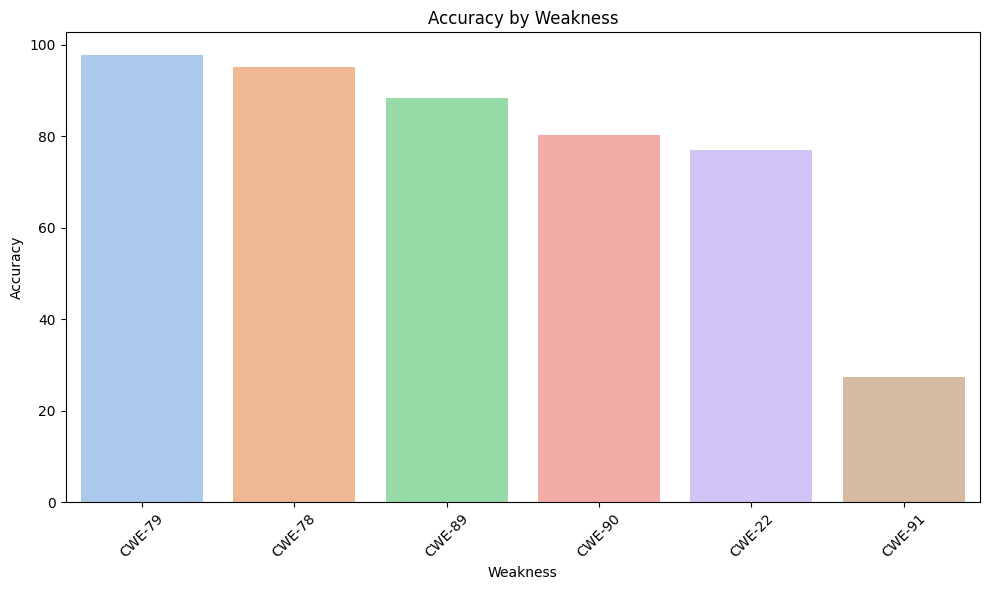

In [175]:
plot_per_weakness_accuracy(all_datasets, relaxed=False)

In [176]:
weaknesses_accuracies = all_datasets.get_merged_per_iteration_weaknessses_accuracies(relaxed=False)

In [177]:
def plot_per_weakness_accuracy_per_iteration(weaknesses_accuracies: dict):
    # Create a violin plot for each weakness across iterations
    records = []
    for weakness, accuracies in weaknesses_accuracies.items():
        for i, acc in enumerate(accuracies):
            records.append({
                "Weakness": weakness,
                "Accuracy": acc
            })

    
    df = pl.DataFrame(records)
    plt.figure(figsize=(12, 8))
    sns.violinplot(data=df, x="Weakness", y="Accuracy", palette="pastel", inner="box")
    plt.title("Accuracy by Weakness per Iteration")
    plt.xticks(rotation=45)
    plt.tight_layout()
    tikz.save('tikz/weakness_accuracy_per_iteration.tex')
    plt.show()

/var/folders/_2/d0jdk4lx3hl2vhm1490_4rm40000gn/T/ipykernel_13316/1099298768.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




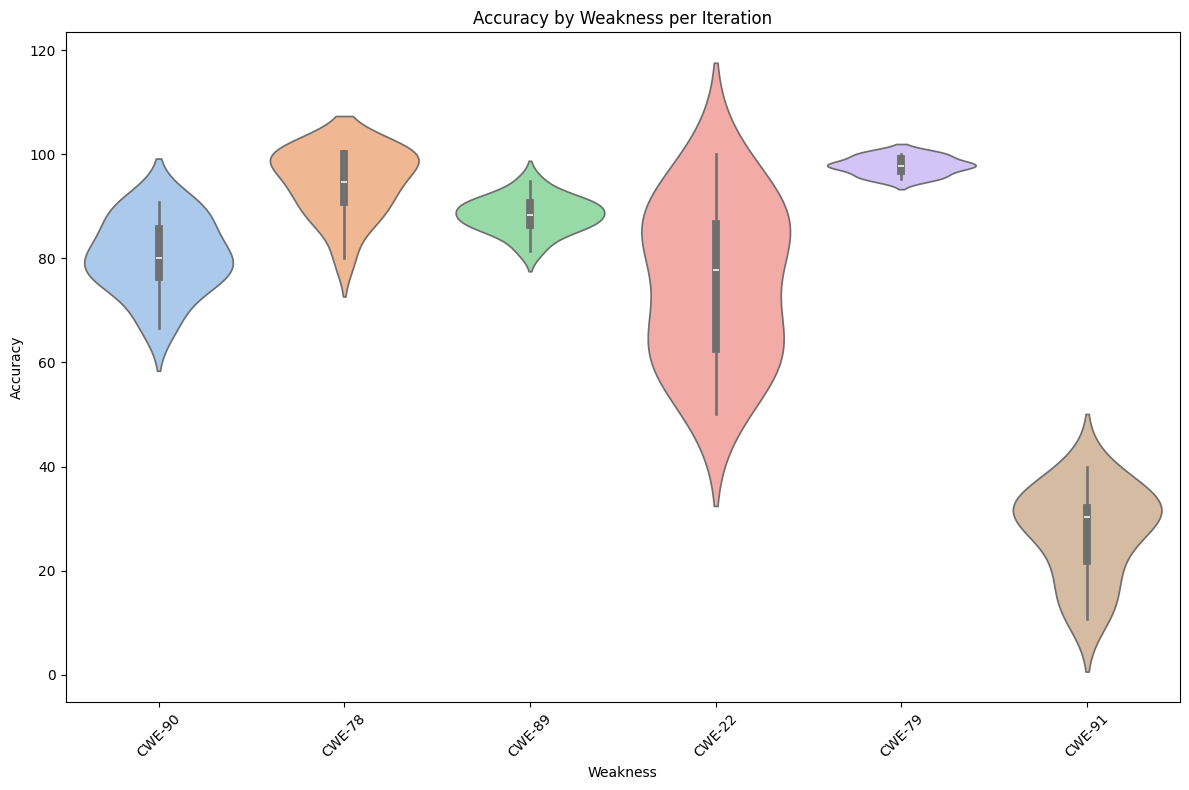

In [178]:
plot_per_weakness_accuracy_per_iteration(weaknesses_accuracies)

# Tests per dataset

In [179]:
from scipy.stats import shapiro, levene, ttest_ind

def do_shapiro(dataset: Dataset):
    # Shapiro-Wilk Test: H0 = data is normally distributed
    accuracies = dataset.get_accuracies_by_iterations(relaxed=False)
    stat, p_value = shapiro(accuracies)

    print("==========================")
    print(f"Shapiro-Wilk Test for {dataset.name}:")
    print(f"Statistic={stat:.4f}, p-value={p_value:.4f}")

    if p_value > 0.05:
        print(f"Fail to reject H₀: Data appears normally distributed (p > 0.05)")
    else:
        print(f"Reject H₀: Data is not normally distributed (p ≤ 0.05)")
    print("==========================\n")


def do_levene(dataset_1: Dataset, dataset_2: Dataset):
    # Levene's Test: H0 = both groups have equal variances
    acc1 = dataset_1.get_accuracies_by_iterations(relaxed=False)
    acc2 = dataset_2.get_accuracies_by_iterations(relaxed=False)
    
    stat, p_value = levene(acc1, acc2)

    print("==========================")
    print(f"Levene's Test between {dataset_1.name} and {dataset_2.name}:")
    print(f"Statistic={stat:.4f}, p-value={p_value:.4f}")

    if p_value > 0.05:
        print("Fail to reject H₀: Variances are equal (p > 0.05)")
    else:
        print("Reject H₀: Variances are significantly different (p ≤ 0.05)")
    print("==========================\n")


def do_ttest(dataset1: Dataset, dataset2: Dataset, equal_var: bool = True):
    # Independent t-test: H0 = means are equal
    acc1 = dataset1.get_accuracies_by_iterations(relaxed=False)
    acc2 = dataset2.get_accuracies_by_iterations(relaxed=False)
    
    stat, p_value = ttest_ind(acc1, acc2, equal_var=equal_var)

    print("==========================")
    print(f"T-test between {dataset1.name} and {dataset2.name}:")
    print(f"Statistic={stat:.4f}, p-value={p_value:.4f}")

    if p_value > 0.05:
        print("Fail to reject H₀: No significant difference in means (p > 0.05)")
    else:
        print("Reject H₀: Significant difference in means (p ≤ 0.05)")
    print("==========================\n")

In [180]:
do_shapiro(csharp_data)
do_shapiro(php_data)

Shapiro-Wilk Test for C#:
Statistic=0.9367, p-value=0.3429
Fail to reject H₀: Data appears normally distributed (p > 0.05)

Shapiro-Wilk Test for PHP:
Statistic=0.9471, p-value=0.4803
Fail to reject H₀: Data appears normally distributed (p > 0.05)



In [181]:
do_levene(csharp_data, php_data)

Levene's Test between C# and PHP:
Statistic=2.3620, p-value=0.1355
Fail to reject H₀: Variances are equal (p > 0.05)



In [182]:
do_ttest(csharp_data, php_data, equal_var=True)

T-test between C# and PHP:
Statistic=4.9807, p-value=0.0000
Reject H₀: Significant difference in means (p ≤ 0.05)



# Tests per weaknesses

In [183]:
from scipy.stats import shapiro, levene, f_oneway, kruskal

def do_shapiro(datasets: DatasetCollection, weakness: str):
    weaknesses_accuracies = datasets.get_merged_per_iteration_weaknessses_accuracies(relaxed=False)
    accuracies = weaknesses_accuracies[weakness]

    if len(accuracies) < 3:
        print(f"Not enough data for Shapiro-Wilk test on {weakness}")
        return

    stat, p_value = shapiro(accuracies)

    print("==========================")
    print(f"Shapiro-Wilk Test for {weakness}:")
    print(f"Statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value > 0.05:
        print("Fail to reject H₀: Data appears normally distributed (p > 0.05)")
    else:
        print("Reject H₀: Data is not normally distributed (p ≤ 0.05)")
    print("==========================\n")

def do_levene(datasets: DatasetCollection):
    weaknesses_accuracies = datasets.get_merged_per_iteration_weaknessses_accuracies(relaxed=False)
    weaknesses = datasets.get_merged_real_test_cases_weakness_count()['Test Case Weakness']

    all_accuracies = [weaknesses_accuracies[weak] for weak in weaknesses if len(weaknesses_accuracies[weak]) >= 2]

    if len(all_accuracies) < 2:
        print("Not enough groups with valid data for Levene's test")
        return

    stat, p_value = levene(*all_accuracies)

    print("==========================")
    print("Levene's Test between weaknesses:")
    print(f"Statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value > 0.05:
        print("Fail to reject H₀: Variances are equal (p > 0.05)")
    else:
        print("Reject H₀: Variances are significantly different (p ≤ 0.05)")
    print("==========================\n")
import polars as pl
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

def do_weighted_anova(datasets: DatasetCollection):
    # Get accuracies per iteration per weakness (assumed to be a dict)
    weaknesses_accuracies = datasets.get_merged_per_iteration_weaknessses_accuracies(relaxed=False)

    # Get weakness counts from Polars DataFrame and convert to dictionary
    weaknesses_count_pl = datasets.get_merged_real_test_cases_weakness_count()
    weaknesses_count = dict(zip(
        weaknesses_count_pl['Test Case Weakness'].to_list(),
        weaknesses_count_pl['count'].to_list()
    ))

    # Build dataset for weighted ANOVA
    data = []
    for weakness, acc_list in weaknesses_accuracies.items():
        if weakness not in weaknesses_count:
            continue
        if len(acc_list) < 2:
            continue  # Need at least two accuracy values for ANOVA

        weight = weaknesses_count[weakness]
        for acc in acc_list:
            data.append({
                'weakness': weakness,
                'accuracy': acc,
                'weight': weight
            })

    # Convert to pandas DataFrame
    df = pd.DataFrame(data)

    if df['weakness'].nunique() < 2:
        print("Not enough groups with valid data for weighted ANOVA")
        return

    # Perform weighted least squares ANOVA
    model = smf.wls('accuracy ~ C(weakness)', data=df, weights=df['weight']).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print("==========================")
    print("Weighted ANOVA (WLS) Test between weaknesses:")
    print(anova_table)
    p_value = anova_table['PR(>F)'][0]
    if p_value > 0.05:
        print("Fail to reject H₀: No significant difference between groups (p > 0.05)")
    else:
        print("Reject H₀: Significant difference between groups (p ≤ 0.05)")
    print("==========================\n")
    
def do_kruskal(datasets: DatasetCollection):
    weaknesses_accuracies = datasets.get_merged_per_iteration_weaknessses_accuracies(relaxed=False)
    weaknesses = datasets.get_merged_real_test_cases_weakness_count()['Test Case Weakness']

    all_accuracies = [weaknesses_accuracies[weak] for weak in weaknesses if len(weaknesses_accuracies[weak]) >= 2]

    if len(all_accuracies) < 2:
        print("Not enough groups with valid data for Kruskal-Wallis test")
        return

    stat, p_value = kruskal(*all_accuracies)

    print("==========================")
    print("Kruskal-Wallis H-test between weaknesses:")
    print(f"Statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value > 0.05:
        print("Fail to reject H₀: No significant difference between groups (p > 0.05)")
    else:
        print("Reject H₀: Significant difference between groups (p ≤ 0.05)")
    print("==========================\n")

In [184]:
for weakness in all_datasets.get_merged_real_test_cases_weakness_count()['Test Case Weakness']:
    do_shapiro(all_datasets, weakness)

Shapiro-Wilk Test for CWE-91:
Statistic=0.9236, p-value=0.2187
Fail to reject H₀: Data appears normally distributed (p > 0.05)

Shapiro-Wilk Test for CWE-22:
Statistic=0.9540, p-value=0.5893
Fail to reject H₀: Data appears normally distributed (p > 0.05)

Shapiro-Wilk Test for CWE-89:
Statistic=0.9886, p-value=0.9986
Fail to reject H₀: Data appears normally distributed (p > 0.05)

Shapiro-Wilk Test for CWE-78:
Statistic=0.8278, p-value=0.0086
Reject H₀: Data is not normally distributed (p ≤ 0.05)

Shapiro-Wilk Test for CWE-90:
Statistic=0.9541, p-value=0.5917
Fail to reject H₀: Data appears normally distributed (p > 0.05)

Shapiro-Wilk Test for CWE-79:
Statistic=0.8839, p-value=0.0544
Fail to reject H₀: Data appears normally distributed (p > 0.05)



In [185]:
do_levene(all_datasets)

Levene's Test between weaknesses:
Statistic=11.9988, p-value=0.0000
Reject H₀: Variances are significantly different (p ≤ 0.05)



In [186]:
do_weighted_anova(all_datasets)
do_kruskal(all_datasets)

Weighted ANOVA (WLS) Test between weaknesses:
                   sum_sq    df           F        PR(>F)
C(weakness)  2.197799e+07   5.0  255.181461  3.177794e-49
Residual     1.446932e+06  84.0         NaN           NaN
Reject H₀: Significant difference between groups (p ≤ 0.05)

Kruskal-Wallis H-test between weaknesses:
Statistic=67.9957, p-value=0.0000
Reject H₀: Significant difference between groups (p ≤ 0.05)



/var/folders/_2/d0jdk4lx3hl2vhm1490_4rm40000gn/T/ipykernel_13316/4197365095.py:88: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

